In [ ]:
"""

THIS SCRIPT IS MOSTLY A SANDBOX.

THE FUNCTIONS USED HERE ARE FORMALLY DEFINED (AND COMMENTED) IN 'ValidationMetrics_[production].ipynb'


"""

In [45]:
import numpy as np
import pandas as pd
import geopandas
import xarray as xr

from rasterio import features
from affine import Affine

import matplotlib.pyplot as plt
from pylab import rcParams

%matplotlib inline
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', None)
rcParams['figure.figsize'] = (12,8)


In [3]:
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['y'], coords['x'])
    out_shape = (len(coords['y']), len(coords['x']))
    raster = features.rasterize(shapes, out_shape=out_shape, transform = transform,
                                fill=fill, all_touched = True,
                                dtype=float, **kwargs)
    
    return xr.DataArray(raster, coords=coords, dims=('y', 'x'))

In [94]:
default_shapefile_filepath = "/home/603/rp1375/Desktop/Link to project/Burn_Mapping/02_Fire_Perimeters_Polygons/NSW_RFS_Outlines/NSW_Fire_History/WildFireHistory.shp"
default_reference_DataArray = xr.open_dataset('/g/data/xc0/project/Burn_Mapping/01_LS_Reflectance_and_Indices/MtDavidStateForest_NBAR_cloudmasked_ls8.nc')


def _CreateValidatedBurnMask( shapefile_filepath = default_shapefile_filepath, 
                             reference_DataArray = default_reference_DataArray ):
    """### FUNCTION NOTES ####
    
    'shapefile_filepath' must be a file path
    'reference_DataArray' must be a xr.DataSet or xr.DataArray. i.e. it must already be opened with xr.open_dataset etc.
    
    ##########################
    """
    
    assert type(shapefile_filepath) is str, 'shapefile_filepath must be a filepath string'
    

    ############## 1) Load in the Shapefile and crop to the correct extent  ##########
    #define location of Shapefile
    df = geopandas.read_file(shapefile_filepath)
    #define projection of shapefile 
    df.crs = {'init' :'epsg:4326'}    
    #Convert to same projection as the input netcdf DataArray
    df = df.to_crs({'init': 'epsg:3577'})

    #format shapefile attributes to datetime64 format
#    df.IGN_DATE = df.IGN_DATE.astype('datetime64[ns]')
    df.ENDDATE = df.ENDDATE.astype('datetime64[ns]')

    x_extent = [reference_DataArray.x.min() , reference_DataArray.x.max()]
    y_extent = [reference_DataArray.y.min() , reference_DataArray.y.max()]
    df = df.cx[ x_extent[0]:x_extent[1] , y_extent[0]:y_extent[1]]

    ####OPTIONAL EXTRA CONSTRAINTS
    #crop only fires with burned area greater than 8x8 landsat pixels (i.e. 500x500 m2)
#    df = df[df.SHAPE_AREA > 25*10000]
    #crop by area and timestamp
#    df = df[df.IGN_DATE > '2003-01-01']
    df = df[df.ENDDATE > '2003-01-01']     
    
    ############## 2) Convert to Xarray DataArray using the coordinates from 'reference_DataArray' ##########
    try:
        del(output_array)
    except NameError:
        pass

    coords = reference_DataArray.drop('time').coords

    for date in np.unique(df.ENDDATE):
        shapes = [(shape,1) for  n, shape in enumerate(df[df.ENDDATE == date].geometry)]
        
        #print(date)
        try:
            new_da = rasterize(shapes , coords)
            new_da = new_da.assign_coords(time = date)
            new_da = new_da.expand_dims('time')
            output_array = xr.concat((output_array,new_da), dim='time')
            #print('success!')
  
        except NameError:
            output_array = rasterize(shapes , coords)
            output_array = output_array.assign_coords(time = date)
            output_array = output_array.expand_dims('time')
            #print('first')
            

    #output_array = output_array.dropna(dim='time',how='all')
    
    return(output_array)
    #return(df)

In [95]:
def _plot_RGB(xarray_dataset = None):
    rgb = xarray_dataset[['red','green','blue']]
    rgb = rgb.to_array(dim='color',name=None)
    
    fake_saturation = 2000
    
    rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
    rgb = rgb.where((rgb <= fake_saturation).all(dim='color'))  # mask out pixels where any band is 'saturated'
    rgb /= fake_saturation  # scale to [0, 1] range for imshow
    rgb.plot.imshow(x='x',y='y', col='time', col_wrap=3, add_colorbar=False)

In [96]:
Validation_Mask = _CreateValidatedBurnMask()
Validation_Mask = Validation_Mask.sel(time=slice('2013','2018')).sum('time')

I am densified (external_values, 1730 elements)


In [97]:
%cd /g/data/xc0/user/renzullo/forRam

A = np.fromfile('AllChangeMask_d01.rst', dtype=np.float32)
A = np.reshape(A,(287,289))
A = np.transpose(A)
GeoMedMask_d01 = Validation_Mask.copy()
GeoMedMask_d01.values = A

A = np.fromfile('AllChangeMask_d02.rst', dtype=np.float32)
A = np.reshape(A,(287,289))
A = np.transpose(A)
GeoMedMask_d02 = Validation_Mask.copy()
GeoMedMask_d02.values = A

A = np.fromfile('AllChangeMask_d03.rst', dtype=np.float32)
A = np.reshape(A,(287,289))
A = np.transpose(A)
GeoMedMask_d03 = Validation_Mask.copy()
GeoMedMask_d03.values = A

A = np.fromfile('AllChangeMask_d04.rst', dtype=np.float32)
A = np.reshape(A,(287,289))
A = np.transpose(A)
GeoMedMask_d04 = Validation_Mask.copy()
GeoMedMask_d04.values = A

A = np.fromfile('AllChangeMask_d05.rst', dtype=np.float32)
A = np.reshape(A,(287,289))
A = np.transpose(A)
GeoMedMask_d05 = Validation_Mask.copy()
GeoMedMask_d05.values = A

A = np.fromfile('AllChangeMask_d06.rst', dtype=np.float32)
A = np.reshape(A,(287,289))
A = np.transpose(A)
GeoMedMask_d06 = Validation_Mask.copy()
GeoMedMask_d06.values = A

A = np.fromfile('AllChangeMask_d07.rst', dtype=np.float32)
A = np.reshape(A,(287,289))
A = np.transpose(A)
GeoMedMask_d07 = Validation_Mask.copy()
GeoMedMask_d07.values = A

A = np.fromfile('AllChangeMask_d08.rst', dtype=np.float32)
A = np.reshape(A,(287,289))
A = np.transpose(A)
GeoMedMask_d08 = Validation_Mask.copy()
GeoMedMask_d08.values = A


/g/data1a/xc0/user/renzullo/forRam


In [98]:
def validate(Test_Array = None, Validated_Array = None):
    """
    Inputs:
    ----------------------
        Test_Array is an xarray DataArray with values 0 and 1 
        Validated_Array is an xarray DataArray with values 0 and 1 
    
    """
    import xarray
    assert type(Test_Array) is xarray.core.dataarray.DataArray, 'Test_Array not an xarray DataArray'
    assert type(Validated_Array) is xarray.core.dataarray.DataArray, 'Validated_Array not an xarray DataArray'
    #assert all(np.isin(Test_Array,[0,1])), 'Test_Array contains values other than 0 and 1'
    #assert all(np.isin(Validated_Array,[0,1])), 'Validated_Array contains values other than 0 and 1'

    
    Correct = Validated_Array.where(Validated_Array==1).where(Test_Array==1)+2
    Correct = Correct.fillna(0)
    Omission = Validated_Array.where(Validated_Array==1).where(Test_Array==0)+1
    Omission = Omission.fillna(0)
    Commission = Validated_Array.where(Validated_Array==0).where(Test_Array==1)+1
    Commission = Commission.fillna(0)
    
    Combined = Correct + Omission + Commission
    Combined = Combined.where(Combined.values!=0)
    
    from matplotlib.colors import ListedColormap
    cMap = ListedColormap(['white','blue', 'red','green'])
    
    Combined.plot(levels=[0,1, 2, 3, 4], cmap=cMap, )
    
    e11 = Correct.sum(('x','y')).values
    e12 = Commission.sum(('x','y')).values
    e21 = Omission.sum(('x','y')).values
    
    commission_error_ratio = e12/(e11+e12)
    omission_error_ratio = e21/(e11+e21)
    dice_coeff = (2*e11)/(2*e11+e12+e21)
    bias = e12 - e21
    
    metrics = {'commission_error_ratio': commission_error_ratio,
              'omission_error_ratio': omission_error_ratio,
               'dice_coeff': dice_coeff,
               'bias': bias
              }
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index')
    metrics_df.columns = list(['value'])
    
    
    return(metrics_df)
    

,value
commission_error_ratio,0.571429
omission_error_ratio,0.772502
dice_coeff,0.297222
bias,-2648.000000


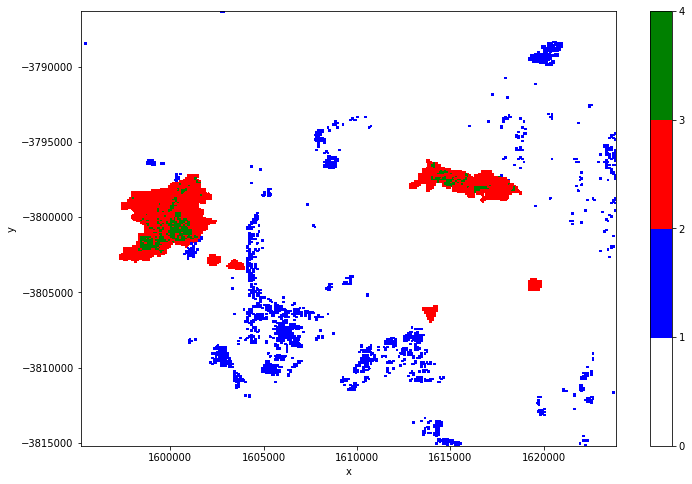

In [310]:
validate(Test_Array=GeoMedMask_d01,Validated_Array=Validation_Mask)

,value
commission_error_ratio,0.713997
omission_error_ratio,0.684508
dice_coeff,0.300024
bias,601.000000


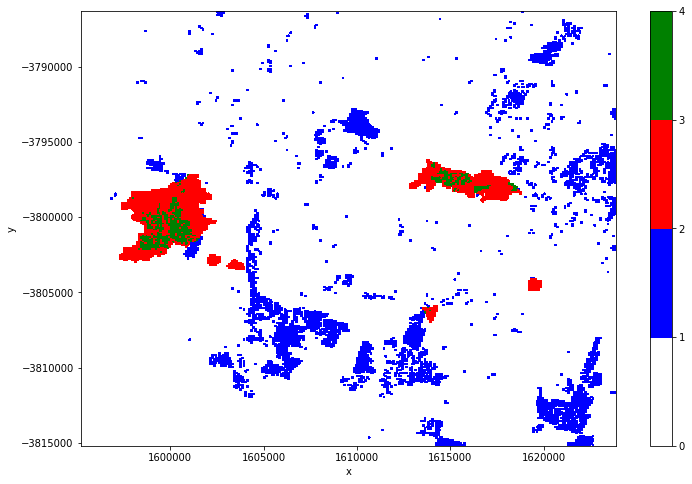

In [311]:
validate(Test_Array=GeoMedMask_d02,Validated_Array=Validation_Mask)

,value
commission_error_ratio,0.768214
omission_error_ratio,0.621106
dice_coeff,0.287622
bias,3789.000000


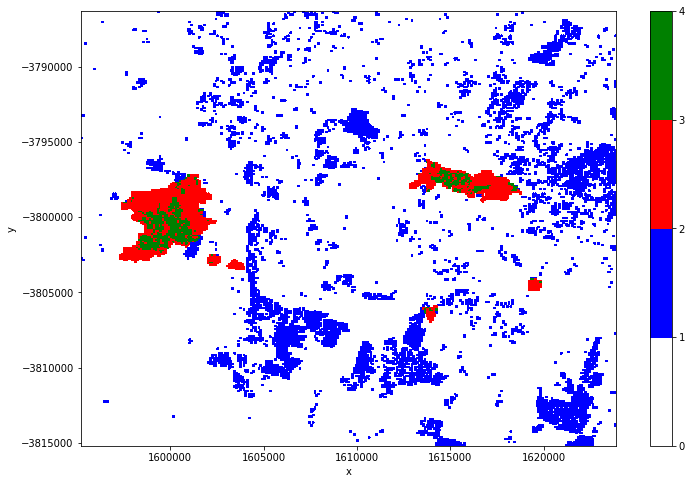

In [312]:
validate(Test_Array=GeoMedMask_d03,Validated_Array=Validation_Mask)

,value
commission_error_ratio,0.738821
omission_error_ratio,0.646372
dice_coeff,0.300453
bias,2093.000000


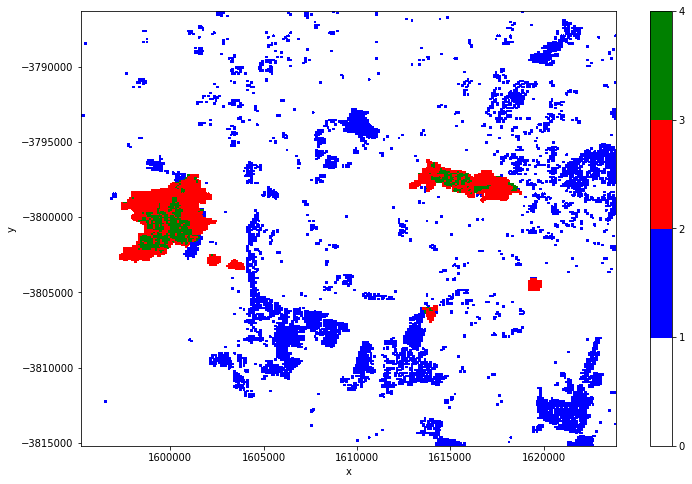

In [313]:
validate(Test_Array=GeoMedMask_d04,Validated_Array=Validation_Mask)

,value
commission_error_ratio,0.691602
omission_error_ratio,0.762712
dice_coeff,0.268210
bias,-1306.000000


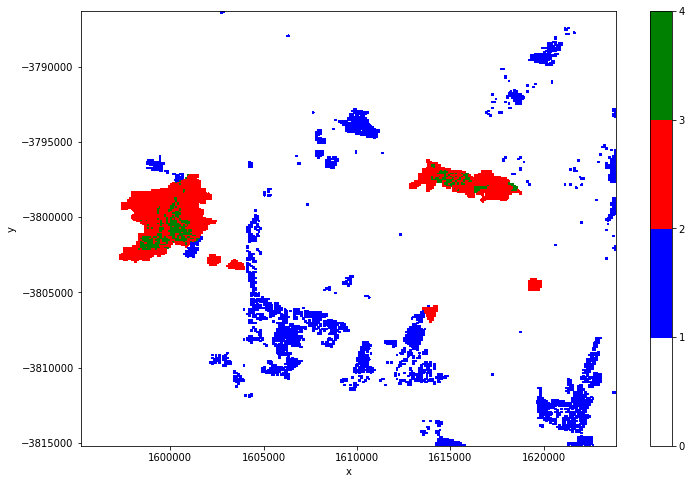

In [314]:
validate(Test_Array=GeoMedMask_d05,Validated_Array=Validation_Mask)

,value
commission_error_ratio,0.675352
omission_error_ratio,0.730414
dice_coeff,0.294566
bias,-972.000000


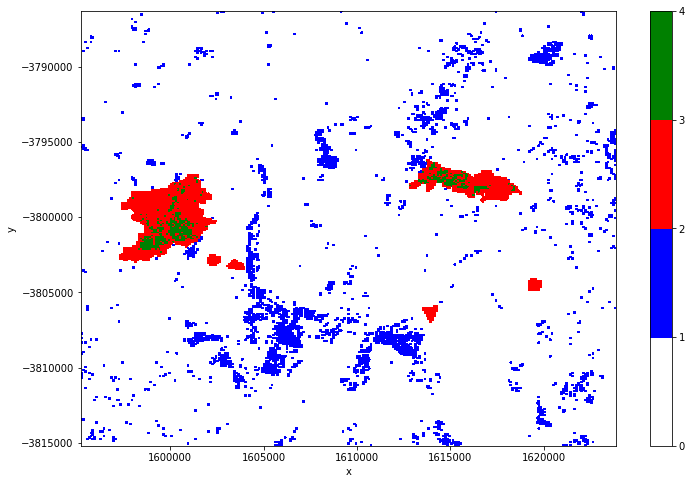

In [99]:
validate(Test_Array=GeoMedMask_d06,Validated_Array=Validation_Mask)

,value
commission_error_ratio,0.662883
omission_error_ratio,0.788311
dice_coeff,0.260070
bias,-2088.000000


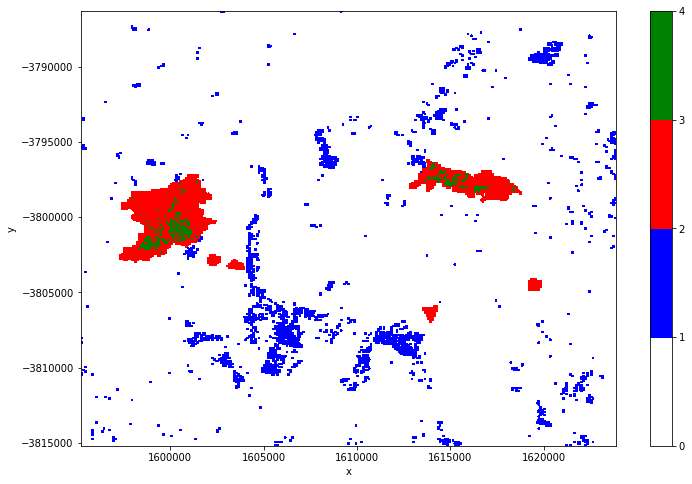

In [100]:
validate(Test_Array=GeoMedMask_d07,Validated_Array=Validation_Mask)

,value
commission_error_ratio,0.649943
omission_error_ratio,0.833243
dice_coeff,0.225901
bias,-2892.000000


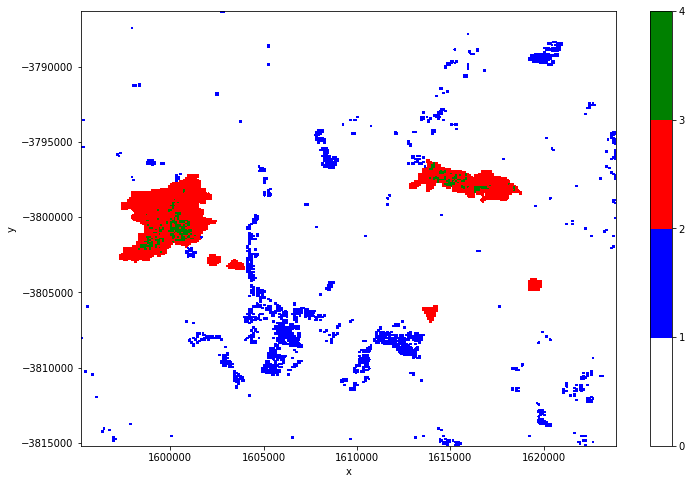

In [101]:
validate(Test_Array=GeoMedMask_d08,Validated_Array=Validation_Mask)

In [320]:
RGB_subset = default_reference_DataArray.sel(time=slice('2013','2018'))

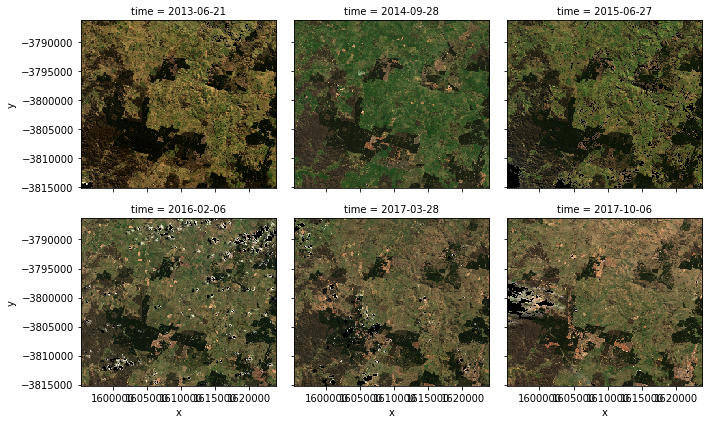

In [347]:
_plot_RGB(
RGB_subset.sel(time = 
              np.isnan(RGB_subset.green).sum(('x','y'))/(len(RGB_subset.x)*len(RGB_subset.y))<0.05).isel(
            time =[0,6,12,18,24,30])
        )

In [91]:
def _forward_fill(Input_DataArray):
    temp_array = Input_DataArray
    
    for i in np.arange(0,len(temp_array.time)):
        temp_array = temp_array.fillna(temp_array.shift(time=1))
    
    return(temp_array)


def _identify_burned_area(Input_DataArray,lag0_threshold = -0.30, lag1_threshold = -0.15):
    
    A = _forward_fill(Input_DataArray)
    B1 = A - A.shift(time=1)
    B2 = A.shift(time=-1)-A.shift(time=1)
    
    C = B1.where(B1 < lag0_threshold)
    D = (B1 < lag0_threshold) & (B2 < lag1_threshold)
    
    return D

In [60]:
data = default_reference_DataArray
NBR = (data.nir - data.swir1) / (data.nir + data.swir1)

In [92]:
NBR_Burn_Area = _identify_burned_area(NBR.resample(time='45D').max('time').dropna('time',how='all')
                                     ).resample(time='AS-SEP').max('time').isel(time=1)

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


,value
commission_error_ratio,0.895662
omission_error_ratio,0.713840
dice_coeff,0.152919
bias,10048.000000


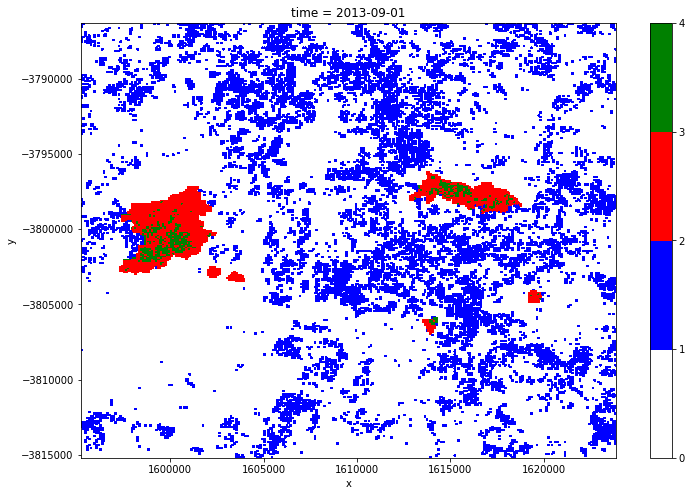

In [93]:
validate(Test_Array=NBR_Burn_Area, Validated_Array=Validation_Mask) 